In [140]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from itertools import islice
import matplotlib.pyplot as plt
%matplotlib inline

### (a) data processing

In [10]:
# load data:
train_l = open('./data/train.txt','r').readlines()
test_l = open('./data/test.txt','r').readlines()

Line of training set:

'/000/003 ham need 1 fw 1 35 2 39 1 thanks 1 thread 2 40 1 copy 1 else 1 correlator 1 under 1 companies 1 25 1 he 2 26 2 168 1 29 2 content 4 1 1 6 1 5 1 4 1 review 2 we 1 john 3 17 1 use 1 15 1 20 1 classes 1 may 1 a 1 back 1 l 1 01 1 produced 1 i 1 yes 1 10 2 713 2 v6 1 p 1 original 2 doc 2 2001 4 comments 1 x 3 week 1 to 6 harry 2 110 1 smtpsvc 1 has 1 who 1 sender 1 would 1 any 2 jan 5 be 1 index 1 text 1 intended 1 and 2 urn 1 email 2 cc 1 1600 1 can 1 re 2 corp 3 fri 2 response 1 65 1 plain 1 confidential 1 853 1 you 6 mailto 1 anything 1 am 1 our 3 they 1 for 6 info 1 of 2 are 3 on 1 exchange 1 topic 1 information 5 transfer 1 or 3 msmbx01v 3 4418 1 questions 1 now 1 them 1 pm 2 mime 1 binary 1 subject 3 tnef 1 nahou 4 version 1 thank 2 encoding 1 contracts 1 me 2 tuesday 2 ena 6 trading 1 just 1 let 1 ms 2 return 1 0500 2 attach 1 attached 1 account 1 mimeole 1 but 1 send 1 individual 1 him 1 type 1 192 1 2195 1 sent 2 enron 9 please 3 when 1 contract 1 class 1 here 1 msmbx05v 1 company 6 this 4 call 1 have 1 june 2 currently 1 while 1 if 2 path 1 find 1 with 4 is 2 it 1 error 1 your 2 agreement 2 the 6 in 2 know 1 their 1 energy 1\n'

In [49]:
# define a function to construct a data structure containing 'id', 'lable', 'word_count':
def pre_processing(line):
    '''
    {
    'id': '/000/003',
     'label': 0 if ham, 1 if spam,
     'word_count': {'need': 1,'fw': 1, ... ...}
    }
    '''
    d = {}
    comp = line[:-1].split(' ')
    d['id'] = comp[0]
    d['label'] = 1 if comp[1]=='spam' else 0
    key = comp[2:][::2]
    value = [int(x) for x in comp[3:][::2]]
    d['word_count'] = dict(zip(key, value))       
    return d
# iterate over lines in train_l and test_l:
def generate_docu(lines):
    output = []
    for line in lines: 
        output.append(pre_processing(line))
    return output

In [54]:
train_docu = generate_docu(train_l)
test_docu = generate_docu(test_l)

### (b) Using the training data, compute the prior probabilities $P(spam)$ and $P(ham)$

p(spam) = number of spam/ number of all; p(ham) = 1 - p(spam)

In [59]:
# get the spam and ham subsets in train_docu:
train_docu_spam = list(filter(lambda x: x['label']==1, train_docu))
train_docu_ham = list(filter(lambda x: x['label']==0, train_docu))

In [62]:
print('p(spam) = ', len(train_docu_spam)/len(train_docu))
print('p(ham) = ', 1- len(train_docu_spam)/len(train_docu))

p(spam) =  0.5736666666666667
p(ham) =  0.42633333333333334


### (c) Determine the vocabulary and compute the conditional probabilities $P(w_i|spam)$ and $P (w_i |ham)$

$P(w_j|spam) = (n_c + mp)/(n + m) $

In [68]:
# construct a new word_count dictionary for all vocabulary
def get_word_count(data):
    word_dict = {}
    for i in data:
        for key, value in i['word_count'].items(): 
            if key in word_dict:
                word_dict[key] = value + word_dict[key]
            else:
                word_dict[key] = value
    return word_dict

In [78]:
train_vb = get_word_count(train_docu)
spam_vb = get_word_count(train_docu_spam)
ham_vb = get_word_count(train_docu_ham)

In [155]:
# define a funciton to compute the conditional probabilities:
def m_estimate(train_vb, sub_vb, word_l, m_coef = 1):
    result = {}
    n = np.sum(list(sub_vb.values()))
    train_sum = len(list(train_vb.values()))
    m = m_coef * train_sum
    p = 1/train_sum
    for w_j in word_l:
        #print(w_j)
        try: 
            n_c = sub_vb[w_j]
        except:
            n_c = 0
        result[w_j]=(n_c + m*p)/(n+m)
    return result

In [113]:
spam_result = m_estimate(train_vb, spam_vb, list(train_vb.keys()))
ham_result = m_estimate(train_vb, ham_vb, list(train_vb.keys()))

In [114]:
# sort both spam and ham results by value in descending order
ham_result_ordered = OrderedDict(sorted(ham_result.items(), key=lambda x: x[1], reverse=True))
spam_result_ordered = OrderedDict(sorted(spam_result.items(), key=lambda x: x[1], reverse=True))

In [115]:
# get the top 5 words: 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

ham_top = take(5, ham_result_ordered.keys())
spam_top = take(5, spam_result_ordered.keys())

In [116]:
print('5 most likely words given a document is ham are ',ham_top)
print('5 most likely words given a document is spam are ',spam_top)

5 most likely words given a document is ham are  ['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'enron', 'the', 'to', 'a']
5 most likely words given a document is spam are  ['enron', 'a', 'corp', 'the', 'to']


### (d)  Use these probabilities to classify the test data and report the accuracy

In [156]:
def classifier(train_docu, test_docu, m_coef):
    train_docu_spam = list(filter(lambda x: x['label']==1, train_docu))
    train_docu_ham = list(filter(lambda x: x['label']==0, train_docu))
    # calcualte p_spam, p_ham
    p_spam, p_ham = len(train_docu_spam)/len(train_docu), 1-len(train_docu_spam)/len(train_docu)
    # construct vocabulary
    train_vb = get_word_count(train_docu)
    spam_vb = get_word_count(train_docu_spam)
    ham_vb = get_word_count(train_docu_ham)
    # compute the word_spam/ham conditional probabilities
    spam_result = m_estimate(train_vb, spam_vb, list(train_vb.keys()), m_coef)
    ham_result = m_estimate(train_vb, ham_vb, list(train_vb.keys()), m_coef)
    
    pred = []
    for docu in test_docu:
        word_l = list(docu['word_count'].keys())
        # compute log-prob of being spam/ham
        log_p_spam, log_p_ham = np.log(p_spam), np.log(p_ham)
        for w_i, w_count in docu['word_count'].items():
            log_p_spam = log_p_spam + w_count * np.log(spam_result[w_i])
            log_p_ham = log_p_ham + w_count * np.log(ham_result[w_i])
        pred.append(log_p_spam > log_p_ham)
    return pred

In [150]:
def accuracy(preds, test_docu):
    true_l = [i['label'] for i in test_docu]
    sum = 0
    for i in range(len(preds)):
        sum += (true_l[i] == preds[i])
    return sum/len(preds)

In [159]:
preds = classifier(train_docu, test_docu, m_coef=1)

In [160]:
accuracy(preds, test_docu)

0.902

### (e) Vary the m parameter, using m = |V ocabulary| × [1, 10, 100, 1000, 10000] and plot the accuracies vs. m

In [161]:
m_coef_l = [1, 10, 100, 1000, 10000]
results = []
for m_coef in m_coef_l:
    preds = classifier(train_docu, test_docu, m_coef)
    results.append(accuracy(preds, test_docu))

In [162]:
results

[0.902, 0.904, 0.904, 0.871, 0.765]

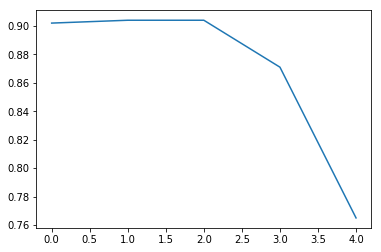

In [163]:
plt.plot(np.log10(m_coef_l), results)

m are weights given to the prior probabilities. A large m indicates we are more confident about the prior distribution, the training set are less taken into account in making prediction; when m is small, we assume that the training set is representitive to the population, and we trust less on prior distritbution. 

Observed from the accuracy curve, as m becomes larger, the accuracy rate goes up a bit then decreases dramatically. 

### (f) If you were a spammer, how would you modify your emails to beat the classifiers we have learned above?

if I were the spammer, to aviod being label as spam, we should increase the amount of 'ham' word in the email, so the email will be less likely to be classified as spam. 